# 2026 QMW - Genomics Module

January 5, 2026

Author: Erik Owen | Graduate Student in Computational & Systems Biology | Page Lab

# Goals:

- QC summary from FASTQ
- Alignment (BAM) & index
- Coverage & MAPQ summaries
- Variant calls (VCF)
- Comparison to ground truth VCF

# Environment Setup

- download software tools + packages that we'll use in this tutorial
- download toy data

### What does `!` mean?

In Colab/Jupyter, you'll see lines that start with an exclamation mark, like `!ls` or `!bowtie2 --version`.

`!` tells the notebook: “run the rest of this line as a shell command (like you typed it in a Terminal), not as Python.”

- `!ls` lists files in the current folder
- `!pwd` prints the current folder path
- `!curl ...` is a command-line tool for data transfer
- `!zcat file.fastq.gz | head` runs a small pipeline of command-line tools
  - `|` is called a "pipe". This sends the output of the command on the left directly into the command on the right so you can "stream" results without creating intermediate files.

*Important*: `!` only works inside notebook cells. If you copy the same line into a .sh bash script, you must remove the `!` (because scripts are already “shell mode”).

In [17]:
!curl -L https://raw.githubusercontent.com/erik-owen/2026_QMW_Genomics/main/scripts/bootstrap_colab.sh | bash


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1751  100  1751    0     0  16538      0 --:--:-- --:--:-- --:--:-- 16676
> Installing tools...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.5M    0 25.5M    0     0  21.5M      0 --:--:--  0:00:01 --:--:-- 27.3M
Tools installed.

Tool versions:
/usr/bin/bowtie2-align-s version 2.4.4
samtools 1.13
bcftools 1.13

5.2
FastQC v0.11.9

> Downloading workshop data...
  - locus1_hg38_chr11_5215464_5237071_HBB.fa
  % Total    % Received % Xferd  Averag

The `tree` command is a UNIX command-line utility that shows your directory + file structure.

We'll be using it throughout the notebook to show you what files we're creating + using!

In [18]:
!tree

.
├── data
│   └── loci
│       ├── locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.fa
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.fa
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed
│       └── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz
├── sample_data
│   ├── anscombe.json
│   ├── california_housing_test.csv
│   ├── california_housing_train.csv
│   ├── mnist_test.csv
│   ├── mnist_train_small.csv
│   └── README.md
└── work

4 directories, 13 files


In [19]:
#@title Select case study inputs
CASE = 1  #@param {type:"integer", min:1, max:2}
SAMPLE = "ind1_noHbS"  #@param ["ind1_noHbS", "ind2_HbS_carrier", "ind1_repeat_mix"]

from pathlib import Path

DATA = Path("data") / "loci"
assert DATA.exists(), f"Missing {DATA}. Did the bootstrap step run?"

FILES = {
    (1, "ind1_noHbS"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind1_noHbS.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (1, "ind2_HbS_carrier"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (2, "ind1_repeat_mix"): dict(
        ref=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.fa",
        reads=DATA / "locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz",
        repeats=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed",
    ),
}

paths = FILES[(CASE, SAMPLE)]
for k, p in paths.items():
    assert p.exists(), f"Missing {k}: {p}"
paths


{'ref': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa'),
 'reads': PosixPath('data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz'),
 'repeats': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed')}

# Sequencing & File formats

## Inpsect a FASTA file

FASTA files is a text-based format for representing a sequence.

It has two parts:
- header: begins with `>`, + single line description of sequence
- sequence representation: 1 letter per nucleic acid

You've been provided 2 FASTA files. Go ahead and inpsect them using the command line:

- locus1_hg38_chr11_5215464_5237071_HBB.fa
- locus2_hg38_chr8_96243643_96263643_MTERF3.fa

In [20]:
!echo "FASTA heads:"
!echo
!head -n 3 data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
!echo
!head -n 3 data/loci/locus2_hg38_chr8_96243643_96263643_MTERF3.fa


FASTA heads:

>locus1_hg38_chr11_5215464_5237071_HBB
GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGAT
GCAAGCCACTGTGCCCAGCTTGGCTCTTTCTTTTTATTTTAATTGGTCACTTTGTTTTCA

>locus2_hg38_chr8_96243643_96263643_MTERF3
TTTAAGGGAAGTGATCTATTCCAAAGTAAAGTAGAGAAAAACATGAGAGAGAAGAGAGAC
TACATTAGATTTGTTGGCCTGATTCCAACAATCAGAACTAGGACTAGGTAGAAACTCCAG


Now, using `python`, inspect our first case study. Return:
- FASTA header
- sequence length
- GC% content
- first 80 base pairs

Note: we've stored the paths to our data in: the paths dict. You want to select the `*.fa` file under `paths["ref"]`

In [21]:
import re # package for regular expressions

def read_fasta_one(path):
    header = None
    seq_chunks = []
    with open(path, "rt") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                header = line[1:]
            else:
                seq_chunks.append(line)
    if header is None:
        raise ValueError(f"No FASTA header found in {path}")
    seq = "".join(seq_chunks).upper()
    return header, seq

def gc_fraction(seq: str) -> float:
    gc = sum(1 for b in seq if b in ("G","C"))
    atgc = sum(1 for b in seq if b in ("A","T","G","C"))
    return (gc / atgc) if atgc else float("nan")

ref_path = paths["ref"]
header, ref_seq = read_fasta_one(ref_path)

print("FASTA:", ref_path.name)
print("Header:", header)
print("Length (bp):", len(ref_seq))
print("GC fraction:", round(gc_fraction(ref_seq), 4))
print("First 80 bp:", ref_seq[:80])

# Extract chr/start/end if present in header or filename
m = re.search(r"(chr[\w]+)[:_](\d+)[-_](\d+)", header) or re.search(r"(chr[\w]+)_(\d+)_(\d+)", ref_path.name)
if m:
    chrom, start, end = m.group(1), int(m.group(2)), int(m.group(3))
    print("Parsed locus:", chrom, start, end, "(span:", end-start, "bp )")


FASTA: locus1_hg38_chr11_5215464_5237071_HBB.fa
Header: locus1_hg38_chr11_5215464_5237071_HBB
Length (bp): 21607
GC fraction: 0.3827
First 80 bp: GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGATGCAAGCCACTGTGCCCAGCT
Parsed locus: chr11 5215464 5237071 (span: 21607 bp )


Does this FASTA represent:
- the whole human genome?
- 1 chromosome?
- a small region?

Why would your above answer be appropriate for a class setting?

Answer in MITx

## Inspect a FASTQ file

What do reads look like?

Using the command line, here are the first 2 records in our FASTQ file.

FASTQ files are composed of 4 lines. What do they signify?


In [22]:
!zcat data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz | head -n 8

@ind1_noHbS_R1_1
CAGTTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTATAAATTACCTTGGGCAGTATGACCATTTTCACGATATTGATTCTTCCT
+
DGDB?ECACCADCEBDGBEI>E;C;<??>@><?;?>;<C=>A:=B<<6;<=?9>:;57;8::9;;:8=88999;9762<6445574:3;58393354513
@ind1_noHbS_R1_2
AGAAATCACCCGTCTTCTGCGTCACTCACGATGGGAGCTATAGACTGGAGCTGTTCCTATTCGGTCATCTTGGCTCCACCGCTCCCCCCCCCCTTTTTTT
+
G@BE=AC?DDAEDCA>@DBBB@C?ED>CB:=>BC?:=;C><@;@>79<=>;:<C<7>=;?=696=<87:67772648985375606:6:;562:22823/


Preview a few FASTQ records, then compute:

- number of reads
- read length
- quick quality summary + plot

In the next cell, please implement the function `phred33_to_q`

In [23]:
def phred33_to_q(qual: str):
  """
  Convert a FASTQ quality string (Phred+33 encoding) into numeric Q scores.

  Inputs:
  qual is string, see the assert checks for examples
  # See https://en.wikipedia.org/wiki/Phred_quality_score#Symbols for more

  Each character encodes a base quality:
    Q = ord(character) - 33

  Example:
    "I!" -> [40, 0]


  Returns
  -------
  list[int]
      One Q score per base; same length as `qual`.
  """
  # TODO
  # hint: use list comprehension for one-liner
  return [ord(c) - 33 for c in qual]

assert phred33_to_q("!") == [0]
assert phred33_to_q("I") == [40]
assert phred33_to_q("?") == [30]
assert phred33_to_q("I!I?") == [40, 0, 40, 30]
print("phred33_to_q sanity checks passed")

phred33_to_q sanity checks passed


In [48]:
import gzip
from statistics import mean

def fastq_iter_gz(path):
  opener = gzip.open if str(path).endswith(".gz") else open
  with opener(path, "rt") as f:
    while True:
      h = f.readline().rstrip()
      if not h:
        return
      s = f.readline().rstrip()
      plus = f.readline().rstrip()
      q = f.readline().rstrip()
      yield h, s, plus, q

reads_path = paths["reads"]

# Preview first 3 records
it = fastq_iter_gz(reads_path)
for i in range(3):
    h, s, plus, q = next(it)
    print("---- record", i+1, "----")
    print(h)
    print("seq (first 60):", s[:60], "...")
    print("qual(first 60):", q[:60], "...")
    print("len:", len(s), "meanQ:", round(mean(phred33_to_q(q)), 2))

# Stream stats
n_reads = 0
lengths = []
mean_qs = []

for h, s, plus, q in fastq_iter_gz(reads_path):
    n_reads += 1
    lengths.append(len(s))
    mean_qs.append(mean(phred33_to_q(q)))

---- record 1 ----
@ind1_noHbS_R1_1
seq (first 60): CAGTTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTATAAATTAC ...
qual(first 60): DGDB?ECACCADCEBDGBEI>E;C;<??>@><?;?>;<C=>A:=B<<6;<=?9>:;57;8 ...
len: 100 meanQ: 26.85
---- record 2 ----
@ind1_noHbS_R1_2
seq (first 60): AGAAATCACCCGTCTTCTGCGTCACTCACGATGGGAGCTATAGACTGGAGCTGTTCCTAT ...
qual(first 60): G@BE=AC?DDAEDCA>@DBBB@C?ED>CB:=>BC?:=;C><@;@>79<=>;:<C<7>=;? ...
len: 100 meanQ: 26.82
---- record 3 ----
@ind1_noHbS_R1_3
seq (first 60): TATAAAAAATGGTGTGGGGGAGGGTTTGGAAAGATTTTTTGGGTAGTATAGAGAAGTTTA ...
qual(first 60): BBDFFGFFDEC?>F@AA@;;B?C>==9><B>>>@<CB9<>?B<<<8=9;=9;@??::839 ...
len: 100 meanQ: 26.42


In [25]:
# Teacher notebook: return all answers
print("\nFASTQ:", reads_path.name)
print("Reads:", n_reads)
print("Read length: min/mean/max =", min(lengths), round(mean(lengths), 2), max(lengths))
print("Mean Q (per-read): min/mean/max =", round(min(mean_qs),2), round(mean(mean_qs),2), round(max(mean_qs),2))



FASTQ: locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
Reads: 2471
Read length: min/mean/max = 100 100 100
Mean Q (per-read): min/mean/max = 25.64 26.5 27.4


In [26]:
# Student notebook:
print("MITx checkpoint: submit the number of reads in this FASTQ.")
print("Sanity check: this is on the order of 10^3")


MITx checkpoint: submit the number of reads in this FASTQ.
Sanity check: this is on the order of 10^3


### Per-base quality profile

Now, we want to explore the quality of our reads which is given by our Phred quality scores:

$Q=-10\log_{10} P$

Where $P$ is the probability of an calling that base incorrectly!


In [27]:
import math

for Q in [10, 20, 30, 40]:
    p = 10 ** (-Q/10)
    print(f"Q={Q}: error probability ≈ {p:g} (≈ 1 in {round(1/p):,} bases)")


Q=10: error probability ≈ 0.1 (≈ 1 in 10 bases)
Q=20: error probability ≈ 0.01 (≈ 1 in 100 bases)
Q=30: error probability ≈ 0.001 (≈ 1 in 1,000 bases)
Q=40: error probability ≈ 0.0001 (≈ 1 in 10,000 bases)


In [28]:
# Student notebook:
print("MITx checkpoint: What is the mean Q per-read in our raw FASTQ file?")
print("Does this make you worry about the errors? Think about the frequency of SNPs in a given human.")


MITx checkpoint: What is the mean Q per-read in our raw FASTQ file?
Does this make you worry about the errors? Think about the frequency of SNPs in a given human.


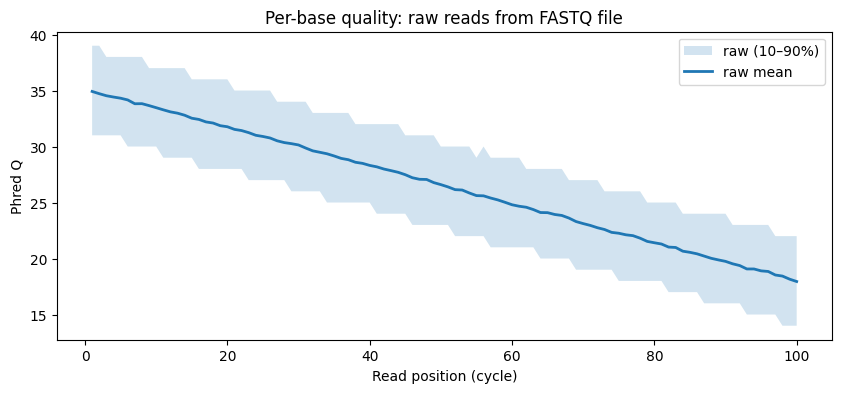

Raw reads processed: 2471
Raw mean Q by cycle:    min/median/max = 17.95 26.5 34.92


In [49]:
import numpy as np
import matplotlib.pyplot as plt

def fastq_iter_gz(path):
    opener = gzip.open if str(path).endswith(".gz") else open
    with opener(path, "rt") as f:
        while True:
            h = f.readline().rstrip()
            if not h:
                return
            s = f.readline().rstrip()
            plus = f.readline().rstrip()
            q = f.readline().rstrip()
            yield h, s, plus, q

def per_base_q_profile(fastq_path, min_count_per_cycle=50):
    """
    Returns dict with x (1-based cycles), mean, p10, p90, n_reads.
    For variable-length reads (trimmed), cycles with <min_count_per_cycle are dropped.
    """
    per_cycle = []  # list of lists of Q values
    n_reads = 0

    for _, s, _, qstr in fastq_iter_gz(fastq_path):
        q = phred33_to_q(qstr)
        if len(per_cycle) < len(q):
            per_cycle.extend([[] for _ in range(len(q) - len(per_cycle))])
        for i, qi in enumerate(q):
            per_cycle[i].append(int(qi))
        n_reads += 1

    # Convert to arrays and compute stats, keeping only cycles with enough observations
    means, p10s, p90s, xs = [], [], [], []
    for i, vals in enumerate(per_cycle):
        if len(vals) < min_count_per_cycle:
            continue
        v = np.array(vals, dtype=np.int16)
        xs.append(i + 1)  # 1-based cycle
        means.append(float(v.mean()))
        p10s.append(float(np.percentile(v, 10)))
        p90s.append(float(np.percentile(v, 90)))

    return {
        "x": np.array(xs, dtype=int),
        "mean": np.array(means, dtype=float),
        "p10": np.array(p10s, dtype=float),
        "p90": np.array(p90s, dtype=float),
        "n_reads": n_reads,
    }

# Paths
reads_raw = paths["reads"]
raw = per_base_q_profile(reads_raw, min_count_per_cycle=50)

plt.figure(figsize=(10,4))

# Raw: gray band + black mean line
plt.fill_between(raw["x"], raw["p10"], raw["p90"], alpha=0.20, label="raw (10–90%)")
plt.plot(raw["x"], raw["mean"], linewidth=2, label="raw mean")

plt.xlabel("Read position (cycle)")
plt.ylabel("Phred Q")
plt.title("Per-base quality: raw reads from FASTQ file")
plt.legend()
plt.show()

print("Raw reads processed:", raw["n_reads"])
print("Raw mean Q by cycle:    min/median/max =",
      round(raw["mean"].min(),2), round(np.median(raw["mean"]),2), round(raw["mean"].max(),2))

Does the quality drop at the 3' end? Why might you think so?

Hint: Think back to sequencing-by-synthesis and the optical readout!

## Quality trimming

Here, we are going to use the tool TrimGalore to remove low quality portions of our read!

This is a pretty typical part of the QC pipeline

https://github.com/FelixKrueger/TrimGalore/tree/master

### Trim all FASTQs in toy data

This precomputes all TrimGalore outputs for all toy FASTQs.

This way we don't have to redo this section for the other provided FASTQs

In [50]:
from pathlib import Path
import shutil

# TRY ADJUSTING THESE PARAMETERS AND RERUN!
# What happend downstream?
Q_TRIM = 20
MIN_LEN = 50

WORK = Path("work")
WORK.mkdir(exist_ok=True)

def work_dir(case: int, sample: str) -> Path:
    d = WORK / f"case{case}_{sample}"
    d.mkdir(parents=True, exist_ok=True)
    return d

def run_trim_galore(case: int, sample: str) -> Path:
    reads = FILES[(case, sample)]["reads"]
    outdir = work_dir(case, sample) / "trim_galore"

    # Clear and rerun
    if outdir.exists():
        shutil.rmtree(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== Trimming (rebuild): case{case} / {sample} ===")
    print("Input:", reads)
    print("Outdir:", outdir)
    print(f"Params: Q_TRIM={Q_TRIM}, MIN_LEN={MIN_LEN}")

    # Run Trim Galore (single-end)
    # !!! IMPORTANT !!!
    !trim_galore --quality {Q_TRIM} --length {MIN_LEN} --fastqc --gzip -o {outdir} {reads}

    trimmed = sorted(outdir.glob("*_trimmed.f*q.gz"))
    assert trimmed, f"Trim Galore finished but no trimmed FASTQ found in {outdir}"

    # If multiple (unexpected for single-end), pick the newest
    trimmed_path = max(trimmed, key=lambda p: p.stat().st_mtime)
    return trimmed_path

# Run for all defined samples
trimmed_map = {}
for (case, sample) in FILES.keys():
    trimmed_path = run_trim_galore(case, sample)
    trimmed_map[(case, sample)] = trimmed_path
    print("Trimmed FASTQ:", trimmed_path)

print("\nDone. Trimmed files available for later alignment:")
trimmed_map



=== Trimming (rebuild): case1 / ind1_noHbS ===
Input: data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
Outdir: work/case1_ind1_noHbS/trim_galore
Params: Q_TRIM=20, MIN_LEN=50
Multicore support not enabled. Proceeding with single-core trimming.
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 5.2
single-core operation.
Proceeding with 'gzip' for decompression
To decrease CPU usage of decompression, please install 'igzip' and run again

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)

Output will be written into the directory: /content/work/case1_ind1_noHbS/trim_galore/


AUTO-DETECTING ADAPTER TYPE
Attempting to auto-detect adapter type from the first 1 million sequences of the first file (>> data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz <<)

Found perfect matches for the following adapter sequences:
Adapter type	Count	Sequence	Sequen

{(1,
  'ind1_noHbS'): PosixPath('work/case1_ind1_noHbS/trim_galore/locus1_HBB.ind1_noHbS.reads_R1_trimmed.fq.gz'),
 (1,
  'ind2_HbS_carrier'): PosixPath('work/case1_ind2_HbS_carrier/trim_galore/locus1_HBB.ind2_HbS_carrier.reads_R1_trimmed.fq.gz'),
 (2,
  'ind1_repeat_mix'): PosixPath('work/case2_ind1_repeat_mix/trim_galore/locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1_trimmed.fq.gz')}

In [51]:
!tree work

work
├── case1_ind1_noHbS
│   └── trim_galore
│       ├── locus1_HBB.ind1_noHbS.reads_R1.fastq.gz_trimming_report.txt
│       ├── locus1_HBB.ind1_noHbS.reads_R1_trimmed_fastqc.html
│       ├── locus1_HBB.ind1_noHbS.reads_R1_trimmed_fastqc.zip
│       └── locus1_HBB.ind1_noHbS.reads_R1_trimmed.fq.gz
├── case1_ind2_HbS_carrier
│   └── trim_galore
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz_trimming_report.txt
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1_trimmed_fastqc.html
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1_trimmed_fastqc.zip
│       └── locus1_HBB.ind2_HbS_carrier.reads_R1_trimmed.fq.gz
└── case2_ind1_repeat_mix
    └── trim_galore
        ├── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz_trimming_report.txt
        ├── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1_trimmed_fastqc.html
        ├── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1_trimmed_fastqc.zip
        └── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1_trimmed.fq.gz

6 directories,

In [52]:
outdir = work_dir(CASE, SAMPLE) / "trim_galore"

trimmed = sorted(outdir.glob("*_trimmed.fq.gz")) + sorted(outdir.glob("*_trimmed.fastq.gz"))
assert len(trimmed) == 1, f"Expected 1 trimmed file, found: {trimmed}"
reads_trimmed = trimmed[0]
reads_trimmed

import gzip, numpy as np

def fastq_stats_gz(path):
    n = 0
    lens = []
    with gzip.open(path, "rt") as f:
        while True:
            h = f.readline()
            if not h:
                break
            s = f.readline().rstrip()
            f.readline()
            f.readline()
            n += 1
            lens.append(len(s))
    lens = np.array(lens)
    return n, int(lens.min()), float(lens.mean()), int(lens.max())

n0, mn0, av0, mx0 = fastq_stats_gz(reads_in)
n1, mn1, av1, mx1 = fastq_stats_gz(reads_trimmed)

print("RAW    reads:", n0, "len min/mean/max:", mn0, round(av0,2), mx0)
print("TRIM   reads:", n1, "len min/mean/max:", mn1, round(av1,2), mx1)

# Checkpoint
print("MITx checkpoint: submit trimmed read count and mean trimmed length.")


RAW    reads: 2471 len min/mean/max: 100 100.0 100
TRIM   reads: 2471 len min/mean/max: 71 91.5 100
MITx checkpoint: submit trimmed read count and mean trimmed length.


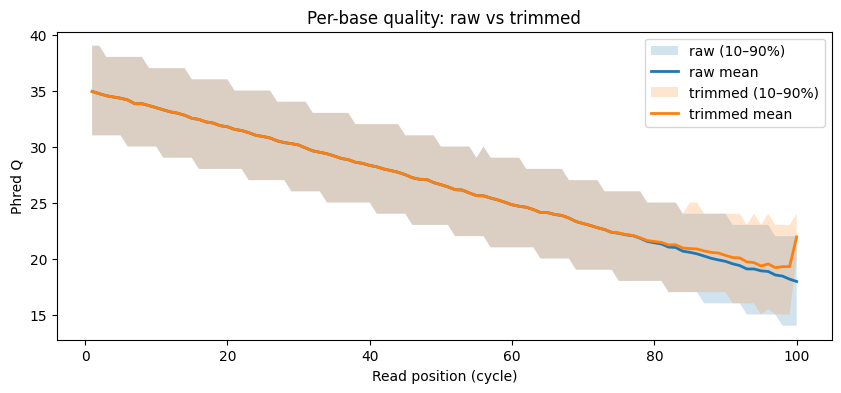

Raw reads processed: 2471
Trimmed reads processed: 2471
Raw mean Q by cycle:    min/median/max = 17.95 26.5 34.92
Trimmed mean Q by cycle: min/median/max = 19.18 26.5 34.92


In [53]:
# Paths
reads_raw = paths["reads"]
reads_trimmed = reads_trimmed  # from your Trim Galore step

raw = per_base_q_profile(reads_raw, min_count_per_cycle=50)
trim = per_base_q_profile(reads_trimmed, min_count_per_cycle=50)

plt.figure(figsize=(10,4))

# Raw: gray band + black mean line
plt.fill_between(raw["x"], raw["p10"], raw["p90"], alpha=0.20, label="raw (10–90%)")
plt.plot(raw["x"], raw["mean"], linewidth=2, label="raw mean")

# Trimmed: blue band + blue mean line
# (Matplotlib default blue; no need to specify if you prefer default)
plt.fill_between(trim["x"], trim["p10"], trim["p90"], alpha=0.20, label="trimmed (10–90%)")
plt.plot(trim["x"], trim["mean"], linewidth=2, label="trimmed mean")

plt.xlabel("Read position (cycle)")
plt.ylabel("Phred Q")
plt.title("Per-base quality: raw vs trimmed")
plt.legend()
plt.show()

print("Raw reads processed:", raw["n_reads"])
print("Trimmed reads processed:", trim["n_reads"])
print("Raw mean Q by cycle:    min/median/max =",
      round(raw["mean"].min(),2), round(np.median(raw["mean"]),2), round(raw["mean"].max(),2))
print("Trimmed mean Q by cycle: min/median/max =",
      round(trim["mean"].min(),2), round(np.median(trim["mean"]),2), round(trim["mean"].max(),2))


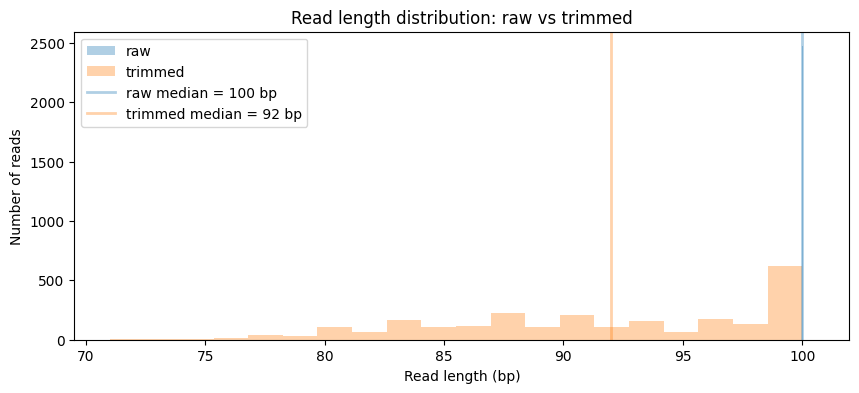

Raw lengths:     n/min/median/mean/max = 2471 100 100 100.0 100
Trimmed lengths: n/min/median/mean/max = 2471 71 92 91.5 100


In [54]:
def read_lengths(fastq_path):
    lens = []
    for _, s, _, _ in fastq_iter_gz(fastq_path):
        lens.append(len(s))
    return np.array(lens, dtype=int)

lens_raw  = read_lengths(reads_raw)
lens_trim = read_lengths(reads_trimmed)

med_raw  = int(np.median(lens_raw))
med_trim = int(np.median(lens_trim))

plt.figure(figsize=(10,4))

# Plot histograms and capture the returned patches to reuse their colors
counts_raw, bins_raw, patches_raw = plt.hist(lens_raw, bins=20, alpha=0.35, label="raw")
counts_tr,  bins_tr,  patches_tr  = plt.hist(lens_trim, bins=20, alpha=0.35, label="trimmed")

raw_color  = patches_raw[0].get_facecolor()
trim_color = patches_tr[0].get_facecolor()

# Median lines in matching colors
plt.axvline(med_raw,  linewidth=2, color=raw_color,  label=f"raw median = {med_raw} bp")
plt.axvline(med_trim, linewidth=2, color=trim_color, label=f"trimmed median = {med_trim} bp")

plt.xlabel("Read length (bp)")
plt.ylabel("Number of reads")
plt.title("Read length distribution: raw vs trimmed")
plt.legend()
plt.show()

print("Raw lengths:     n/min/median/mean/max =",
      len(lens_raw), lens_raw.min(), med_raw, round(lens_raw.mean(),2), lens_raw.max())
print("Trimmed lengths: n/min/median/mean/max =",
      len(lens_trim), lens_trim.min(), med_trim, round(lens_trim.mean(),2), lens_trim.max())


### Run the following cell to get the full QC report from running `fastQC` as part of `TrimGalore`

In [55]:
from google.colab import files


# Feel free to change to other CASE and SAMPLE to inspect other files!
outdir = work_dir(CASE, SAMPLE) / "trim_galore"
trim_dir = outdir

# Find the HTML report
html_candidates = sorted(trim_dir.glob("*_fastqc.html"))
assert html_candidates, f"No *_fastqc.html found in {trim_dir}. Did you run Trim Galore with --fastqc?"

html_path = html_candidates[0]

print("FastQC report found at:", html_path)
print("Instructions:")
print("1) This notebook will download the FastQC HTML report to your computer.")
print("2) Open the downloaded file (fastqc_report.html) in your web browser.")
print("3) Skim these sections: Per base sequence quality, Per sequence quality scores,")
print("   Per base sequence content, Sequence Length Distribution")

# Trigger download
files.download(str(html_path))


FastQC report found at: work/case1_ind1_noHbS/trim_galore/locus1_HBB.ind1_noHbS.reads_R1_trimmed_fastqc.html
Instructions:
1) This notebook will download the FastQC HTML report to your computer.
2) Open the downloaded file (fastqc_report.html) in your web browser.
3) Skim these sections: Per base sequence quality, Per sequence quality scores,
   Per base sequence content, Sequence Length Distribution


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Finish answering questions in the MITx section before moving on to alignment

# Alignment


We will use `bowtie2` to align our trimmed reads to our reference FASTA.

In this module you will:
1. Build a Bowtie2 index from a small reference FASTA (a single locus).
2 . Align trimmed reads to that reference using Bowtie2.
3. Convert the alignments to BAM (binary), sort them, and index them (so tools can query them efficiently).
4. Inspect real alignments and learn to interpret:
    - CIGAR (match/indel/soft clip)
    - MAPQ (confidence in placement)
5. Compute quick summaries:
  - mapping rate
  - MAPQ histogram
  - coverage across the locus
6. Run a mini-experiment: change Bowtie2 settings and see what changes.


Key ideas to keep in mind
- Alignment is an optimization problem: Bowtie2 tries to find the best placement(s) for each read.
- Repeats are tricky because the “best placement” may not be unique.
- MAPQ is about confidence in placement, not base-call quality.

Let's start with the CASE and SAMPLE we defined at the top of this notebook.

In [56]:
from pathlib import Path
import glob

WORK = Path("work")
WORK.mkdir(exist_ok=True)

# Where trim_galore outputs went
case_dir = WORK / f"case{CASE}_{SAMPLE}"
trim_dir = case_dir / "trim_galore"
assert trim_dir.exists(), f"Missing {trim_dir}. Run trimming first."

ref_fa = FILES[(CASE, SAMPLE)]["ref"]

# Find the trimmed FASTQ produced by trim_galore (single-end)
trimmed = list(trim_dir.glob("*_trimmed.fq.gz"))
assert len(trimmed) == 1, f"Expected 1 trimmed FASTQ in {trim_dir}, found: {trimmed}"
trimmed_fq = trimmed[0]

print("CASE:", CASE, "SAMPLE:", SAMPLE)
print("REF:", ref_fa)
print("TRIMMED:", trimmed_fq)


CASE: 1 SAMPLE: ind1_noHbS
REF: data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
TRIMMED: work/case1_ind1_noHbS/trim_galore/locus1_HBB.ind1_noHbS.reads_R1_trimmed.fq.gz


## Build bowtie2 index

We build a **search index** for the locus. Otherwise, we wouldn't have anything to align to!

The following command `bowtie2-build` creates the index prefix.


In [57]:
idx_dir = case_dir / "bowtie2_index"
idx_dir.mkdir(exist_ok=True)
idx_prefix = idx_dir / "ref"

!bowtie2-build "{ref_fa}" "{idx_prefix}"
!ls -lh "{idx_dir}"

Settings:
  Output files: "work/case1_ind1_noHbS/bowtie2_index/ref.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 5401
Using parameters --bmax 4051 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these param

## Align reads

We will run 2 alignments to compare:

- `Bowtie2` default which does end-to-end pairing
- `--very-sensitive-local`

In [58]:
aln_dir = case_dir / "alignments"
aln_dir.mkdir(exist_ok=True)

sam_default = aln_dir / "aln.default.sam"
sam_vsl     = aln_dir / "aln.vslocal.sam"

In [78]:
# 1) Default alignment (end-to-end)
!bowtie2 -x "{idx_prefix}" -U "{trimmed_fq}" -S "{sam_default}" 2> "{sam_default}.log"

# 2) Very-sensitive LOCAL alignment
!bowtie2 --very-sensitive-local -x "{idx_prefix}" -U "{trimmed_fq}" -S "{sam_vsl}" 2> "{sam_vsl}.log"

# Show Bowtie2 summaries (mapping rate, etc.)
!tail -n 20 "{sam_default}.log"
!echo "----"
!tail -n 20 "{sam_vsl}.log"

2471 reads; of these:
  2471 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    2366 (95.75%) aligned exactly 1 time
    105 (4.25%) aligned >1 times
100.00% overall alignment rate
----
2471 reads; of these:
  2471 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    2319 (93.85%) aligned exactly 1 time
    152 (6.15%) aligned >1 times
100.00% overall alignment rate


Try changing Bowtie2 settings to rerun previous step:


Ideas to try:
- `--local vs default` (end-to-end-ish)
- `--very-sensitive` (end-to-end sensitivity preset)
- `--very-sensitive-local` (local + sensitive)

Change the number of reporting alignments:
- `-k 1` (report 1 alignment)
- `-k 5` (report up to 5 alignments per read)


Read the docs here for guidance! https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml#command-line

Does the mapping rate change?

## Convert SAM to BAM and provide mapping summaries

- SAM $:=$ sequence alignment map
- BAM $:=$ binary alignment map

SAM is a text-based format for storing sequences aligned to a reference sequence.

BAM is the lossless, compressed binary version of a SAM


Why do we index?

- Quickly retrive alignments that overlap specific location
- We sort our files to do this


Overview of steps:

- `samtools view -bS` : SAM → BAM
- `samtools sort` : coordinate-sort
- `samtools index` : build .bai index
- `samtools flagstat` : quick stats (mapped/unmapped etc.)

In [79]:
def bam_paths(sam_path: Path):
    bam = sam_path.with_suffix(".bam")
    sortbam = sam_path.with_suffix(".sorted.bam")
    return bam, sortbam

bam_def, sort_def = bam_paths(sam_default)
bam_vsl, sort_vsl = bam_paths(sam_vsl)


In [80]:
# Default BAM
!samtools view -bS "{sam_default}" > "{bam_def}"
!samtools sort -o "{sort_def}" "{bam_def}"
!samtools index "{sort_def}"

# Very-sensitive-local BAM
!samtools view -bS "{sam_vsl}" > "{bam_vsl}"
!samtools sort -o "{sort_vsl}" "{bam_vsl}"
!samtools index "{sort_vsl}"

### SAM field guide

| Col | Field | Type   | Brief description                         |
|-----|-------|--------|--------------------------------------------|
| 1   | QNAME | String | Query template NAME                        |
| 2   | FLAG  | Int    | bitwise FLAG                               |
| 3   | RNAME | String | Reference sequence NAME                    |
| 4   | POS   | Int    | 1-based leftmost mapping POSition          |
| 5   | MAPQ  | Int    | MAPping Quality                            |
| 6   | CIGAR | String | CIGAR string                               |
| 7   | RNEXT | String | Ref. name of the mate/next read            |
| 8   | PNEXT | Int    | Position of the mate/next read             |
| 9   | TLEN  | Int    | observed Template LENgth                   |
| 10  | SEQ   | String | segment SEQuence                           |
| 11  | QUAL  | String | ASCII of Phred-scaled base QUALity + 33    |



In [81]:
!samtools view -h "{sort_def}" | head -n 30


@HD	VN:1.0	SO:coordinate
@SQ	SN:locus1_hg38_chr11_5215464_5237071_HBB	LN:21607
@PG	ID:bowtie2	PN:bowtie2	VN:2.4.4	CL:"/usr/bin/bowtie2-align-s --wrapper basic-0 -x work/case1_ind1_noHbS/bowtie2_index/ref -S work/case1_ind1_noHbS/alignments/aln.default.sam -U work/case1_ind1_noHbS/trim_galore/locus1_HBB.ind1_noHbS.reads_R1_trimmed.fq.gz"
@PG	ID:samtools	PN:samtools	PP:bowtie2	VN:1.13	CL:samtools view -bS work/case1_ind1_noHbS/alignments/aln.default.sam
@PG	ID:samtools.1	PN:samtools	PP:samtools	VN:1.13	CL:samtools sort -o work/case1_ind1_noHbS/alignments/aln.default.sorted.bam work/case1_ind1_noHbS/alignments/aln.default.bam
@PG	ID:samtools.2	PN:samtools	PP:samtools.1	VN:1.13	CL:samtools view -h work/case1_ind1_noHbS/alignments/aln.default.sorted.bam
ind1_noHbS_R1_2336	0	locus1_hg38_chr11_5215464_5237071_HBB	1	42	95M	*	0	0	GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGATGCAAGCCACTGTGCCCAGCTTGGCTCTTTCTTTTT	AADB=BDECDB?EBA>AD@@C<B?G@=C=;><<?C;=:;>7;?@=;:<>=;;<997?8B9;89=8<:;761

Below, we will examine our CIGAR strings in more detail!

Read about CIGAR strings here: https://en.wikipedia.org/wiki/Sequence_alignment#Representations



### Aside: Running shell commands from Python with `subprocess`

Python's `subprocess` module lets you run external command-line programs (like `samtools`) and capture their output. It's the standard replacement for older approaches like `os.system()`.

#### The two most common patterns:

**1) Capture a command's stdout as a string (simple):**
- Use `subprocess.check_output(...)` when you want the command output *and* you want Python to raise an error if the command fails (non-zero exit code).

```python
out = subprocess.check_output(
    "samtools view my.bam | cut -f 6",
    shell=True,     # lets the pipe `|` work (runs via the shell)
    text=True       # returns a Python string instead of bytes
)
```

**2) `subprocess.run` for more control:**

```python
res = subprocess.run(
    ["samtools", "view", "my.bam"],     # no shell; safer and faster
    check=True,                         # raise error if rc != 0
    text=True,
    capture_output=True                 # captures stdout/stderr
)
stdout = res.stdout
```

#### More Notes:

`shell=True` vs list-of args:

- `shell=True` is convenient for pipes `|`, redirection `>`, globbing `*`, etc.
- if any part of command comes from user input, perfer list-of-args to avoid shell-injection problems


**Error handling and debugging:**
- With check_output / run(check=True), failures raise `subprocess.CalledProcessError`.
- Capturing stderr can help diagnose missing tools, bad paths, etc.

```python
try:
    res = subprocess.run(["samtools", "--version"], check=True, text=True, capture_output=True)
except subprocess.CalledProcessError as e:
    print("Command failed:", e)
    print("stderr:", e.stderr)
```

In the code below, we use `check_output(..., shell=True, text=True)` because we're using a shell pipeline (`samtools ... | cut ...`), and we want the resulting text output in Python for parsing.


In [83]:
import subprocess, re
from collections import Counter
import pandas as pd


def cigar_summary(bam_path, max_lines=None):
    # Grab CIGAR (field 6) from samtools view

    # here is the command
    cmd = f"samtools view {bam_path} | cut -f 6"
    if max_lines:
        cmd += f" | head -n {int(max_lines)}"

    # here is the use of subprocess
    out = subprocess.check_output(cmd, shell=True, text=True)
    cigars = [c.strip() for c in out.splitlines() if c.strip()]

    trivial_re = re.compile(r"^\d+M$")   # exactly like "101M"
    is_trivial = [bool(trivial_re.match(c)) for c in cigars]

    return {
        "n_total": len(cigars),
        "n_trivial_M_only": sum(is_trivial),
        "n_nontrivial": len(cigars) - sum(is_trivial),
    }

print("DEFAULT:", cigar_summary(sort_def))
print("VSL-LOC:", cigar_summary(sort_vsl))

def nontrivial_cigar_table(bam_path, n=20):
    # Pull key fields: QNAME FLAG RNAME POS MAPQ CIGAR

    # here is the command!
    cmd = f"samtools view {bam_path} | cut -f 1-6"

    # Here's the use of subprocess
    out = subprocess.check_output(cmd, shell=True, text=True)

    rows = []
    trivial_re = re.compile(r"^\d+M$")
    for line in out.splitlines():
        qname, flag, rname, pos, mapq, cigar = line.split("\t")
        if cigar != "*" and not trivial_re.match(cigar):
            rows.append((qname, int(flag), rname, int(pos), int(mapq), cigar))
            if len(rows) >= n:
                break

    return pd.DataFrame(rows, columns=["QNAME","FLAG","RNAME","POS","MAPQ","CIGAR"])

df_nontriv_vsl = nontrivial_cigar_table(sort_vsl, n=10)
df_nontriv_vsl

DEFAULT: {'n_total': 2471, 'n_trivial_M_only': 2471, 'n_nontrivial': 0}
VSL-LOC: {'n_total': 2471, 'n_trivial_M_only': 2424, 'n_nontrivial': 47}


,QNAME,FLAG,RNAME,POS,MAPQ,CIGAR
0,ind1_noHbS_R1_1355,0,locus1_hg38_chr11_5215464_5237071_HBB,41,44,93M2S
1,ind1_noHbS_R1_2450,0,locus1_hg38_chr11_5215464_5237071_HBB,780,44,98M2S
2,ind1_noHbS_R1_976,0,locus1_hg38_chr11_5215464_5237071_HBB,1467,44,79M1S
3,ind1_noHbS_R1_397,0,locus1_hg38_chr11_5215464_5237071_HBB,1603,44,99M1S
4,ind1_noHbS_R1_1028,0,locus1_hg38_chr11_5215464_5237071_HBB,2452,44,86M2S
5,ind1_noHbS_R1_1475,0,locus1_hg38_chr11_5215464_5237071_HBB,3316,44,89M2S
6,ind1_noHbS_R1_1792,0,locus1_hg38_chr11_5215464_5237071_HBB,3347,44,99M1S
7,ind1_noHbS_R1_964,0,locus1_hg38_chr11_5215464_5237071_HBB,4554,44,90M2S
8,ind1_noHbS_R1_18,0,locus1_hg38_chr11_5215464_5237071_HBB,4597,44,98M2S
9,ind1_noHbS_R1_1306,0,locus1_hg38_chr11_5215464_5237071_HBB,4954,44,94M2S


## MAPQ confidence

MAPQ is about how uniquely / confidently Bowtie2 placed the read.
- High MAPQ: “I'm pretty sure this is the right spot”
- Low MAPQ: “This read could map equally well to multiple places”

We will compare histograms for default vs. a different setting.

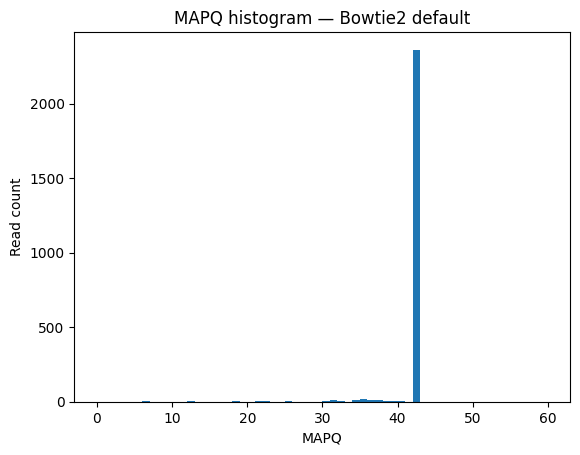

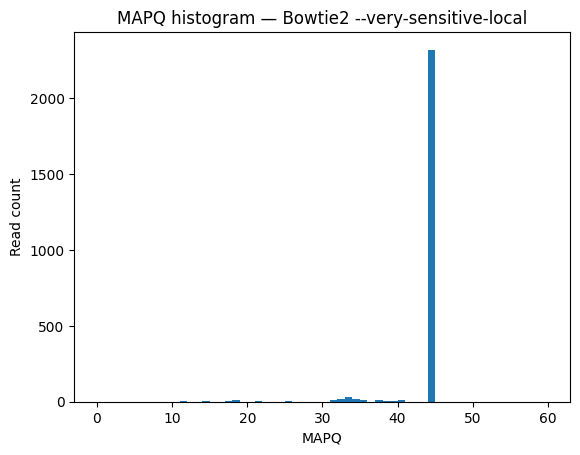

DEFAULT:  n= 2471   fraction MAPQ>=30 = 0.9890732496964791
VSL-LOC:  n= 2471   fraction MAPQ>=30 = 0.9846216106839336


In [84]:
import subprocess, numpy as np
import matplotlib.pyplot as plt

def extract_mapq(bam_path):
    cmd = f"samtools view {bam_path} | cut -f 5"
    out = subprocess.check_output(cmd, shell=True, text=True)
    vals = [int(x) for x in out.strip().split() if x.strip()]
    return np.array(vals, dtype=int)

mapq_def = extract_mapq(sort_def)
mapq_vsl = extract_mapq(sort_vsl)

plt.figure()
plt.hist(mapq_def, bins=range(0, 61, 1))
plt.title("MAPQ histogram — Bowtie2 default")
plt.xlabel("MAPQ")
plt.ylabel("Read count")
plt.show()

plt.figure()
plt.hist(mapq_vsl, bins=range(0, 61, 1))
plt.title("MAPQ histogram — Bowtie2 --very-sensitive-local")
plt.xlabel("MAPQ")
plt.ylabel("Read count")
plt.show()

print("DEFAULT:  n=", len(mapq_def), "  fraction MAPQ>=30 =", (mapq_def>=30).mean())
print("VSL-LOC:  n=", len(mapq_vsl), "  fraction MAPQ>=30 =", (mapq_vsl>=30).mean())


## Compute coverage across locus

Coverage answers: "How many reads overlap each position?"

Sanity check:
- coverage should be approximately smooth for a well-behaving locus
- for repetitive loci, we can get spikes/weird patterns

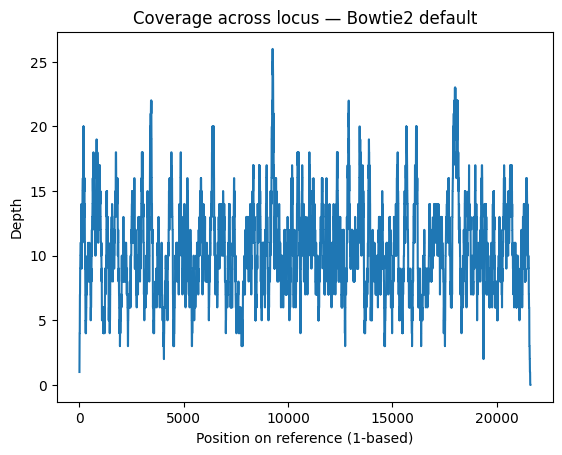

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def coverage_df(bam_path: Path):
    cmd = f"samtools depth -aa {bam_path}"
    out = subprocess.check_output(cmd, shell=True, text=True)
    rows = []
    for line in out.strip().splitlines():
        rname, pos, depth = line.split("\t")
        rows.append((rname, int(pos), int(depth)))
    return pd.DataFrame(rows, columns=["rname","pos","depth"])

cov_def = coverage_df(sort_def)

plt.figure()
plt.plot(cov_def["pos"], cov_def["depth"])
plt.title("Coverage across locus — Bowtie2 default")
plt.xlabel("Position on reference (1-based)")
plt.ylabel("Depth")
plt.show()


# Checkpoint

What is the average coverage across the loci for the default setting?

Round to 1 significant digit.

Hint: use the `describe()` function to explore your `pandas` dataframe.

## Batch alignment pipeline

Run bowtie2 default for all samples.

This is an example pipeline!

1. Locate the trimmed FASTQ from Trim Galore
2. Build a Bowtie2 index for the sample's locus reference
3. Align with Bowtie2 default settings
4. Convert to sorted BAM + index
5. Collect a small summary table (overall alignment rate, etc.)


This gives us a consistent baseline to compare samples—especially before we start tweaking alignment parameters.

In [90]:
from pathlib import Path
import subprocess, re
import pandas as pd

WORK = Path("work")

def sh(cmd: str):
    """Run a shell command; raise if it fails; return CompletedProcess."""
    return subprocess.run(cmd, shell=True, check=True, text=True, capture_output=True)

def find_trimmed_fastq(case: int, sample: str) -> Path:
    trim_dir = WORK / f"case{case}_{sample}" / "trim_galore"
    assert trim_dir.exists(), f"Missing {trim_dir}. Run trimming first."
    trimmed = list(trim_dir.glob("*_trimmed.fq.gz"))
    assert len(trimmed) == 1, f"Expected 1 trimmed FASTQ in {trim_dir}, found: {trimmed}"
    return trimmed[0]

def ensure_bowtie2_index(ref_fa: Path, idx_prefix: Path):
    """Build bowtie2 index only if it doesn't exist."""
    idx_dir = idx_prefix.parent
    idx_dir.mkdir(parents=True, exist_ok=True)

    # bowtie2-build outputs files like ref.1.bt2 (or .bt2l). We'll check for either.
    bt2_files = list(idx_dir.glob(idx_prefix.name + "*.bt2")) + list(idx_dir.glob(idx_prefix.name + "*.bt2l"))
    if len(bt2_files) >= 4:
        return  # index exists

    print(f"[index] building: {idx_prefix}")
    sh(f'bowtie2-build "{ref_fa}" "{idx_prefix}"')

def parse_bowtie2_log(log_text: str) -> dict:
    """
    Pull out a few useful metrics from bowtie2 stderr summary.
    Works with standard bowtie2 summary format.
    """
    out = {}
    m = re.search(r"(\d+(?:\.\d+)?)% overall alignment rate", log_text)
    if m:
        out["overall_alignment_rate_pct"] = float(m.group(1))

    m = re.search(r"(\d+(?:\.\d+)?)% aligned 0 times", log_text)
    if m:
        out["aligned_0x_pct"] = float(m.group(1))

    m = re.search(r"(\d+(?:\.\d+)?)% aligned exactly 1 time", log_text)
    if m:
        out["aligned_1x_pct"] = float(m.group(1))

    m = re.search(r"(\d+(?:\.\d+)?)% aligned >1 times", log_text)
    if m:
        out["aligned_gt1x_pct"] = float(m.group(1))

    return out

def sam_to_sorted_bam(sam_path: Path, out_prefix: Path) -> Path:
    """
    Convert SAM->BAM->sorted BAM and index.
    Returns sorted BAM path.
    """
    bam = out_prefix.with_suffix(".bam")
    sortbam = out_prefix.with_suffix(".sorted.bam")

    sh(f'samtools view -bS "{sam_path}" > "{bam}"')
    sh(f'samtools sort -o "{sortbam}" "{bam}"')
    sh(f'samtools index "{sortbam}"')
    return sortbam

def run_bowtie2_default(case: int, sample: str) -> dict:
    """
    Runs bowtie2 default pipeline for a given (case, sample).
    Saves:
      work/case{case}_{sample}/align_default/
        - aln.default.sam
        - aln.default.sam.log
        - aln.default.sorted.bam (+ .bai)
    """
    case_dir = WORK / f"case{case}_{sample}"
    out_dir = case_dir / "align_default"
    out_dir.mkdir(parents=True, exist_ok=True)

    ref_fa = Path(FILES[(case, sample)]["ref"])
    trimmed_fq = find_trimmed_fastq(case, sample)

    idx_dir = case_dir / "bowtie2_index"
    idx_prefix = idx_dir / "ref"
    ensure_bowtie2_index(ref_fa, idx_prefix)

    sam_path = out_dir / "aln.default.sam"
    log_path = out_dir / "aln.default.sam.log"
    bam_prefix = out_dir / "aln.default"

    print(f"[align] case{case} {sample}")
    # Capture bowtie2 stderr (summary) into a log file
    sh(f'bowtie2 -x "{idx_prefix}" -U "{trimmed_fq}" -S "{sam_path}" 2> "{log_path}"')

    # Convert to sorted BAM
    sortbam = sam_to_sorted_bam(sam_path, bam_prefix)

    log_text = log_path.read_text()
    metrics = parse_bowtie2_log(log_text)

    # Add a couple of paths for convenience
    metrics.update({
        "case": case,
        "sample": sample,
        "ref_fa": str(ref_fa),
        "trimmed_fq": str(trimmed_fq),
        "sorted_bam": str(sortbam),
        "bowtie2_log": str(log_path),
    })

    return metrics


In [91]:
# Run for all configured case/sample combinations
results = []
for (case, sample) in sorted(FILES.keys()):
    results.append(run_bowtie2_default(case, sample))

df = pd.DataFrame(results).sort_values(["case", "sample"])
df


[align] case1 ind1_noHbS
[index] building: work/case1_ind2_HbS_carrier/bowtie2_index/ref
[align] case1 ind2_HbS_carrier
[index] building: work/case2_ind1_repeat_mix/bowtie2_index/ref
[align] case2 ind1_repeat_mix


,overall_alignment_rate_pct,case,sample,ref_fa,trimmed_fq,sorted_bam,bowtie2_log
0,100.0,1,ind1_noHbS,data/loci/locus1_hg38_chr11_5215464_5237071_HB...,work/case1_ind1_noHbS/trim_galore/locus1_HBB.i...,work/case1_ind1_noHbS/align_default/aln.sorted...,work/case1_ind1_noHbS/align_default/aln.defaul...
1,100.0,1,ind2_HbS_carrier,data/loci/locus1_hg38_chr11_5215464_5237071_HB...,work/case1_ind2_HbS_carrier/trim_galore/locus1...,work/case1_ind2_HbS_carrier/align_default/aln....,work/case1_ind2_HbS_carrier/align_default/aln....
2,100.0,2,ind1_repeat_mix,data/loci/locus2_hg38_chr8_96243643_96263643_M...,work/case2_ind1_repeat_mix/trim_galore/locus2_...,work/case2_ind1_repeat_mix/align_default/aln.s...,work/case2_ind1_repeat_mix/align_default/aln.d...


# Pileups & Variant Calling


We aligned to the locus FASTA, so our BAM coordinates are local to that locus contig.

We will use `samtools` to get that fasta index `*.fai` file.

In [102]:
!samtools faidx data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
!cut -f1,2 data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa.fai


locus1_hg38_chr11_5215464_5237071_HBB	21607


Now confirm the BAM is aligned against the same contig name

In [111]:
from pathlib import Path
import subprocess, textwrap

REF = Path("data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa")

BAM1 = Path("work/case1_ind1_noHbS/align_default/aln.sorted.bam")
BAM2 = Path("work/case1_ind2_HbS_carrier/align_default/aln.sorted.bam")

case = 1
for BAM in [BAM1, BAM2]:

  contig = sh(f"samtools view -H {BAM} | awk -F'\\t' '$1==\"@SQ\"{{for(i=1;i<=NF;i++) if($i~\"^SN:\") {{sub(\"SN:\",\"\",$i); print $i}}}}' | head -n 1").strip()
  print(f"Contig in BAM for case {case}:", contig)
  assert contig, "Could not find contig name in BAM header"
  case += 1


Contig in BAM for case 1: locus1_hg38_chr11_5215464_5237071_HBB
Contig in BAM for case 2: locus1_hg38_chr11_5215464_5237071_HBB


Contig in BAM: locus1_hg38_chr11_5215464_5237071_HBB
